# **Traductor Inglés-Español**

#### **Dataset**

Antes de pasar a datasets de entrenamiento más avanzados, como el del **Europarl**, haremos uso de una dataset muy sencillo para entender el funcionamiento del modelo. Este dataset contiene frases en inglés y su respectiva traducción al español, como se muestra a continuación:

In [1]:
def read_translation(archivo_ingles, archivo_espanol):
    with open(archivo_ingles, 'r', encoding='utf-8') as f_ingles, open(archivo_espanol, 'r', encoding='utf-8') as f_espanol:
        for oracion_ingles, oracion_espanol in zip(f_ingles, f_espanol):
            yield oracion_ingles.strip(), oracion_espanol.strip()


archivo_ingles = 'data/mock/mock.en'
archivo_espanol = 'data/mock/mock.es'

for i, (ingles, espanol) in enumerate(read_translation(archivo_ingles, archivo_espanol)):
    print('Inglés:', ingles)
    print('Español:', espanol)
    print('---')
    if i == 15:
        break

Inglés: Hello
Español: Hola
---
Inglés: Bye
Español: Adiós
---
Inglés: house
Español: casa
---
Inglés: dog
Español: perro
---
Inglés: cat
Español: gato
---
Inglés: head
Español: cabeza
---
Inglés: hand
Español: mano
---
Inglés: yellow
Español: amarillo
---
Inglés: my car
Español: mi coche
---
Inglés: my dog
Español: mi perro
---
Inglés: your cat
Español: tu gato
---


### Dataset de Entrenaiento

Lo primero que haremos será cargar el dataset crear una clase para cargar los datos y preprocesarlos posteriormente para poder entrenar un modelo de traducción. Esta clase, por tanto, heredará de la clase `torch.utils.data.Dataset` y sobreescribirá los métodos `__len__` y `__getitem__`.

In [2]:
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchtext
import torch
from collections import defaultdict

In [3]:
class Translation(Dataset):
    def __init__(self, source_file, target_file):
        self.ingles = []
        self.espanol = []
        self.tokenizer_es = get_tokenizer("spacy", language="es_core_news_md")
        self.tokenizer_en = get_tokenizer("spacy", language="en_core_web_md")
        self.vocab_es = torchtext.vocab.FastText(language='es', unk_init=torch.Tensor.normal_)  # <-- Mirar esto para ver si añadir el token <unk> al vocabulario
        self.vocab_en = torchtext.vocab.FastText(language='en', unk_init=torch.Tensor.normal_)

        self.vocab_en = self.add_sos_eos_unk_pad(self.vocab_en)
        self.vocab_es = self.add_sos_eos_unk_pad(self.vocab_es)

        self.archivo_ingles = source_file
        self.archivo_espanol = target_file

        for ingles, espanol in self.read_translation():
            self.ingles.append(ingles)
            self.espanol.append(espanol)


    def add_sos_eos_unk_pad(self, vocabulary):
        words = vocabulary.itos
        vocab = vocabulary.stoi
        embedding_matrix = vocabulary.vectors

        sos_token = '<sos>'
        eos_token = '<eos>'
        pad_token = '<pad>'
        unk_token = '<unk>'

        sos_vector = torch.full((1, embedding_matrix.shape[1]), 1.)
        eos_vector = torch.full((1, embedding_matrix.shape[1]), 2.)
        pad_vector = torch.zeros((1, embedding_matrix.shape[1]))
        unk_vector = torch.full((1, embedding_matrix.shape[1]), 3.)

        embedding_matrix = torch.cat((embedding_matrix, sos_vector, eos_vector, unk_vector, pad_vector), 0)

        vocab[sos_token] = len(vocab)
        vocab[eos_token] = len(vocab)
        vocab[pad_token] = len(vocab)
        vocab[unk_token] = len(vocab)

        words.append(sos_token)
        words.append(eos_token)
        words.append(pad_token)
        words.append(unk_token)

        vocabulary.itos = words
        vocabulary.stoi = vocab
        vocabulary.vectors = embedding_matrix

        default_stoi = defaultdict(lambda : len(vocabulary)-1, vocabulary.stoi)
        vocabulary.stoi = default_stoi
    
        return vocabulary
        

    def read_translation(self):
        with open(self.archivo_ingles, 'r', encoding='utf-8') as f_ingles, open(self.archivo_espanol, 'r', encoding='utf-8') as f_espanol:
            for oracion_ingles, oracion_espanol in zip(f_ingles, f_espanol):
                yield oracion_ingles.strip().lower(), oracion_espanol.strip().lower()

    def __len__(self):
        return len(self.ingles)

    def __getitem__(self, idx, verbose=False):
        item = self.ingles[idx], self.espanol[idx]
        tokens_ingles = self.tokenizer_en(item[0])
        tokens_espanol = self.tokenizer_es(item[1])

        tokens_ingles = tokens_ingles + ['<eos>']
        tokens_espanol = ['<sos>'] + tokens_espanol + ['<eos>']

        if verbose:
            print('Inglés:', tokens_ingles)
            print('Español:', tokens_espanol)
            print('---')

        if not tokens_ingles or not tokens_espanol:
            return torch.zeros(1, 300), torch.zeros(1, 300)
    
        tensor_ingles = self.vocab_en.get_vecs_by_tokens(tokens_ingles)
        tensor_espanol = self.vocab_es.get_vecs_by_tokens(tokens_espanol)

        indices_ingles = [self.vocab_en.stoi[token] for token in tokens_ingles] + [self.vocab_en.stoi['<pad>']]
        indices_espanol = [self.vocab_es.stoi[token] for token in tokens_espanol] + [self.vocab_es.stoi['<pad>']]

        return tensor_ingles, tensor_espanol, indices_ingles, indices_espanol
        
            
        
def collate_fn(batch):
    ingles_batch, espanol_batch, ingles_seqs, espanol_seqs = zip(*batch)
    ingles_batch = pad_sequence(ingles_batch, batch_first=True, padding_value=0)
    espanol_batch = pad_sequence(espanol_batch, batch_first=True, padding_value=0)

    pad = espanol_seqs[0][-1]
    max_len = max([len(l) for l in espanol_seqs])
    for seq in espanol_seqs:
        seq += [pad]*(max_len-len(seq))
        
    return ingles_batch, espanol_batch, ingles_seqs, espanol_seqs

Ahora sí, cargamos el dataset desde memoria, y mostramos un ejemplo de los datos que contiene.

In [4]:
archivo_ingles = 'data/mock/mock.en'
archivo_espanol = 'data/mock/mock.es'

translation = Translation(archivo_ingles, archivo_espanol)

In [5]:
translation.__getitem__(0, verbose=True);

Inglés: ['hello', '<eos>']
Español: ['<sos>', 'hola', '<eos>']
---


Una vez definido el dataset, instanciaremos un DataLoader para poder iterar sobre los datos durante el entrenamiento.

In [6]:
batch_size = 8
num_workers = 0
shuffle = True

In [7]:
dataloader = DataLoader(translation, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)

Creado el DataLoader, estamos listos para definir el modelo de traducción.

### **Modelo**

A continuación, definiremos un modelo de traducción basado en la arquitectura `Seq2Seq` con `LSTM` como codificador y decodificador. Además, se ha implementado un mecanismo de atención para mejorar la calidad de las traducciones.

En el siguiente código se muestra como instanciar el modelo con la atención de `Luong`, aunque también se puede utilizar la atención de Bahdanau o del producto escalar modificando la variable `attention`, instanciando la clase que corresponda.

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

In [14]:
from seq2seq.attention import DotAttention, LuAttention, BaAttention
from seq2seq.model import LSTM, Seq2Seq

Los token de entrada tendrán una dimensión de 300, mientras que la dimensión de la salida será igual al número de palabras en el vocabulario de salida. La dimensión del estado oculto y de celda de la LSTM será de 512, y se tratará de un LSTM de dos capas para dara un mayor nivel de abstracción al modelo.

En cuanto al entrenamientom se usará un learning rate de $10^{-3}$, y el modelo será entrenado durante 60 épocas, aunque los resultados obtenidos pueden conseguirse con menos épocas aún.

In [10]:
input_dim = 300
output_dim = translation.vocab_es.vectors.shape[0]
hidden_dim = 512
num_layers = 2
learning_rate = 0.001
num_epochs = 60

In [11]:
encoder = LSTM(input_dim, hidden_dim, num_layers)
decoder = LSTM(input_dim, hidden_dim, num_layers)
attention = LuAttention(hidden_dim)

In [12]:
model = Seq2Seq(encoder, decoder, attention, output_dim)

### Entrenamiento

Podemos proceder a entrenar el modelo con el dataset de los datos de prueba. Para ello, se ha definido una función de error de entropía cruzada, pues la salida del decodificador es una clasificación con tantas clases como palabras en el vocabulario. Como optimizador se ha utilizado Adam.

In [15]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

Si entrenamos, obtenemos el siguiente resultado:

In [16]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (src, tgt, src_indices, tgt_indices) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(src, tgt)

        tgt_indices = torch.tensor(tgt_indices, dtype=torch.long)
        
        loss = 0
        for t in range(1, tgt.shape[1]):
            loss += criterion(output[:, t, :], tgt_indices[:, t])

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_idx % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss / len(dataloader):.4f}')

Epoch [1/60], Step [1/2], Loss: 3.4346
Epoch [1/60], Average Loss: 3.9074
Epoch [2/60], Step [1/2], Loss: 3.5249
Epoch [2/60], Average Loss: 3.5407
Epoch [3/60], Step [1/2], Loss: 3.0649
Epoch [3/60], Average Loss: 3.2545
Epoch [4/60], Step [1/2], Loss: 3.1500
Epoch [4/60], Average Loss: 3.3960
Epoch [5/60], Step [1/2], Loss: 2.9901
Epoch [5/60], Average Loss: 3.2021
Epoch [6/60], Step [1/2], Loss: 2.7222
Epoch [6/60], Average Loss: 2.7938
Epoch [7/60], Step [1/2], Loss: 2.8345
Epoch [7/60], Average Loss: 2.6909
Epoch [8/60], Step [1/2], Loss: 2.6888
Epoch [8/60], Average Loss: 2.7444
Epoch [9/60], Step [1/2], Loss: 2.5387
Epoch [9/60], Average Loss: 2.3395
Epoch [10/60], Step [1/2], Loss: 2.4722
Epoch [10/60], Average Loss: 2.3155
Epoch [11/60], Step [1/2], Loss: 2.3013
Epoch [11/60], Average Loss: 2.1969
Epoch [12/60], Step [1/2], Loss: 2.1248
Epoch [12/60], Average Loss: 2.1604
Epoch [13/60], Step [1/2], Loss: 2.0150
Epoch [13/60], Average Loss: 2.1508
Epoch [14/60], Step [1/2], Los

Podemos apreciar cómo, a lo largo de las épocas, el error de entrenamiento disminuye, lo que indica que el modelo está aprendiendo. 

In [17]:
torch.save(model.state_dict(), 'seq2seq_model_retrained.pth')

### Evaluación del modelo

Con el objetivo de comprobar si el modelo ha aprendido algo o no, vamos a evaluarlo sobre el conjunto de los datos de prueba. Es evidente que, si este se prueba con datos distintos, fallará, ya que la enorme falta de datos y el hecho de que no se trata de un modelo preentrenado implican una gran cantidad de sobre ajuste en el modelo. No obstante, esto se corregiría si se utilizara un dataset más grande o un modelo previamente entrenado en otras tareas de traducción.

In [122]:
model = Seq2Seq(encoder, decoder, attention, output_dim)

In [132]:
model.load_state_dict(torch.load('seq2seq_model_retrained.pth'))

<All keys matched successfully>

Usaremos el modelo en modo de evaluación, mediante el método `eval`, el cual permite que no se aplique el backpropagation en las capas de la red.

In [133]:
model.eval()

Seq2Seq(
  (encoder): LSTM(
    (rnn): LSTM(300, 512, num_layers=2, batch_first=True)
  )
  (decoder): LSTM(
    (rnn): LSTM(300, 512, num_layers=2, batch_first=True)
  )
  (attention): LuAttention()
  (fc_out): Linear(in_features=512, out_features=985671, bias=True)
)

In [27]:
def tokenize_sentence(sentence, translation):
    tokens = translation.tokenizer_en(sentence)
    tokens = tokens + ['<eos>']
    text_tensor = translation.vocab_en.get_vecs_by_tokens(tokens)
    text_tensor = text_tensor.unsqueeze(0)
    return text_tensor.repeat(batch_size, 1, 1)

In [28]:
start = translation.vocab_en.get_vecs_by_tokens(['<sos>']).unsqueeze(0)
start = start.repeat(batch_size, 1, 1)

In [29]:
import torch.nn.functional as F

In [29]:
def predict(model, sentence, translation):
    outputs = []
    text_tensor = tokenize_sentence(sentence, translation)
    enc_outputs, (hidden, cell) = model.encoder(text_tensor)
    x = start

    for t in range(1, 10):
        output, (hidden, cell) = model.decoder(x, hidden, cell)
        output = output.squeeze(1)
        att = model.attention(enc_outputs, output)
        output += att
        output = model.fc_out(output)
    
        top1 = output.argmax(1)
        x = translation.vocab_es.vectors[top1].unsqueeze(1)
    
        word = translation.vocab_es.itos[top1[0].item()]
        outputs.append(word)

        if word == '<eos>':
            break

    return outputs

Se obtienen los siguientes resultados:

In [ ]:
sentence = "my dog"
outputs = predict(model, sentence, translation)

In [139]:
outputs

['mi', 'perro', '<eos>']

In [ ]:
sentence = "your cat"
outputs = predict(model, sentence, translation)

In [142]:
outputs

['tu', 'gato', '<eos>']

In [ ]:
sentence = "hello"
outputs = predict(model, sentence, translation)

In [144]:
outputs

['hola', '<eos>']

In [ ]:
sentence = "yellow"
outputs = predict(model, sentence, translation)

In [146]:
outputs

['amarillo', '<eos>']

En efecto, el modelo es capaz de aprender a traducir.

# Traducción de frutas

Con los datos anteriores, surgía un problema relacionado con la atención. Esta técnica es especialmente útil en traducciones de frases largas, donde la traducción de una palabra puede depender del contexto proporcionado por las palabras que la rodean. Sin embargo, en el dataset original, las frases eran cortas y consistían en palabras cuya traducción era directa y única. Por ejemplo, la palabra *cat* siempre se traducía como *gato*, independientemente de su contexto. Así, frases como "the cat" o "your cat" siempre se traducirían con *cat* interpretado como *gato*, sin necesidad de considerar el entorno.

Sin embargo, no todas las palabras tienen una traducción tan sencilla. Tomemos, por ejemplo, la palabra *the*. Su traducción al español depende de cómo se utilice en el contexto de la frase. En "the cat", *the* se traduce como "el", mientras que en "the cats" se traduce como "los". Por tanto, su correcta traducción requiere que el modelo sea capaz de capturar y aprender estas relaciones contextuales.

Para abordar este desafío, construiremos un dataset diseñado específicamente para enfatizar estos casos contextuales. Con este enfoque, evaluaremos si el modelo es capaz de aprender y generalizar correctamente las relaciones contextuales que definen la traducción adecuada en cada situación.

### Conjunto de datos

Entrenaremos ahora el modelo con un dataset que contiene traducciones de distintas frutas junto con su género. El objetivo es ver si gracias a este mecanismo de atención el modelo es capaz de aprender a traducir correctamente las frutas, teniendo en cuenta su género.

Algunas de las traducciones que se encuentran en el dataset son:

- apple -> la manzana
- the banana -> el plátano
- the avocado -> aguacate

Una vez disponemos de dataset en los archivos, lo cargamos haciendo uso de la clase `Translation` que ya tenemos.

In [4]:
archivo_ingles = 'data/mock/mock2.en'
archivo_espanol = 'data/mock/mock2.es'

translation = Translation(archivo_ingles, archivo_espanol)

Un ejemplo real del dataset sería el siguiente:

In [5]:
translation.__getitem__(0, verbose=True);

Inglés: ['the', 'apple', '<eos>']
Español: ['<sos>', 'la', 'manzana', '<eos>']
---


Hecho esto, construimos el objeto `DataLoader` para poder iterar sobre los datos durante el entrenamiento.

In [10]:
batch_size = 12
num_workers = 0
shuffle = True

In [11]:
dataloader = DataLoader(translation, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)

### Modelo

A la vista de los buenos resultados en la sección anterior, vamos a utilizar el mismo modelo para entrenar con este nuevo dataset.

In [22]:
input_dim = 300
output_dim = translation.vocab_es.vectors.shape[0]
hidden_dim = 512
num_layers = 2
learning_rate = 0.001
num_epochs = 60

De nuevo, usaremos la atención de Luong, aunque se puede cambiar a Bahdanau o al producto escalar modificando la variable `attention`.

In [15]:
encoder = LSTM(input_dim, hidden_dim, num_layers)
decoder = LSTM(input_dim, hidden_dim, num_layers)
attention = LuAttention(hidden_dim)

In [16]:
model = Seq2Seq(encoder, decoder, attention, output_dim)

### Entrenamiento

Para el entrenamiento, volveremos a usar la función de error de entropía cruzada y el optimizador Adam. El modelo será entrenado durante 60 épocas.

In [20]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [23]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (src, tgt, src_indices, tgt_indices) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(src, tgt)

        tgt_indices = torch.tensor(tgt_indices, dtype=torch.long)
        
        loss = 0
        for t in range(1, tgt.shape[1]):
            loss += criterion(output[:, t, :], tgt_indices[:, t])

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_idx % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss / len(dataloader):.4f}')

Epoch [1/60], Step [1/3], Loss: 4.7431
Epoch [1/60], Average Loss: 4.7591
Epoch [2/60], Step [1/3], Loss: 4.4260
Epoch [2/60], Average Loss: 4.8636
Epoch [3/60], Step [1/3], Loss: 5.2489
Epoch [3/60], Average Loss: 4.7724
Epoch [4/60], Step [1/3], Loss: 4.6918
Epoch [4/60], Average Loss: 4.6754
Epoch [5/60], Step [1/3], Loss: 4.1265
Epoch [5/60], Average Loss: 4.6351
Epoch [6/60], Step [1/3], Loss: 4.0699
Epoch [6/60], Average Loss: 4.6665
Epoch [7/60], Step [1/3], Loss: 4.4399
Epoch [7/60], Average Loss: 4.5378
Epoch [8/60], Step [1/3], Loss: 4.4718
Epoch [8/60], Average Loss: 4.4461
Epoch [9/60], Step [1/3], Loss: 4.4512
Epoch [9/60], Average Loss: 4.4110
Epoch [10/60], Step [1/3], Loss: 4.1447
Epoch [10/60], Average Loss: 4.4766
Epoch [11/60], Step [1/3], Loss: 4.3345
Epoch [11/60], Average Loss: 4.4148
Epoch [12/60], Step [1/3], Loss: 4.7864
Epoch [12/60], Average Loss: 4.5639
Epoch [13/60], Step [1/3], Loss: 4.4835
Epoch [13/60], Average Loss: 4.7848
Epoch [14/60], Step [1/3], Los

Aunque el error en la última época es ligeramente mayor al error obtenido en la sección anterior con los datos de prueba originales, debemos tener en cuenta que esto se debe a que se trata de un dataset más complejo, y de mayor tamaño.

In [24]:
torch.save(model.state_dict(), 'seq2seq_model_fruits.pth')

### Evaluación del modelo

A continuación, testearemos el modelo, mostrando los resultados de puntuación obtenidos durante la atención en la traducción de las frutas.

In [ ]:
model = Seq2Seq(encoder, decoder, attention, output_dim)

In [ ]:
model.load_state_dict(torch.load('seq2seq_model_fruits.pth'))

<All keys matched successfully>

In [25]:
model.eval()

Seq2Seq(
  (encoder): LSTM(
    (rnn): LSTM(300, 512, num_layers=2, batch_first=True)
  )
  (decoder): LSTM(
    (rnn): LSTM(300, 512, num_layers=2, batch_first=True)
  )
  (attention): LuAttention()
  (fc_out): Linear(in_features=512, out_features=985671, bias=True)
)

In [31]:
def tokenize_sentence(sentence, translation):
    tokens = translation.tokenizer_en(sentence)
    tokens = tokens + ['<eos>']
    text_tensor = translation.vocab_en.get_vecs_by_tokens(tokens)
    text_tensor = text_tensor.unsqueeze(0)
    return text_tensor.repeat(batch_size, 1, 1)

In [32]:
start = translation.vocab_en.get_vecs_by_tokens(['<sos>']).unsqueeze(0)
start = start.repeat(batch_size, 1, 1)

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

In [127]:
def attention_matrix(model, sentence, translation):
    outputs = []
    text_tensor = tokenize_sentence(sentence, translation)
    enc_outputs, (hidden, cell) = model.encoder(text_tensor)
    x = start

    att_matrix = []

    for t in range(1, 10):
        output, (hidden, cell) = model.decoder(x, hidden, cell)
        output = output.squeeze(1)

        att = model.attention(enc_outputs, output)
        output += att

        scores = model.attention._get_scores(enc_outputs, output)
        att_matrix.append(scores[0,:].detach().numpy())

        output = model.fc_out(output)
    
        top1 = output.argmax(1)
        x = translation.vocab_es.vectors[top1].unsqueeze(1)
    
        word = translation.vocab_es.itos[top1[0].item()]
        outputs.append(word)

        if word == '<eos>':
            break

    return outputs, torch.tensor(att_matrix)

In [138]:
def show_att_matrix(sentence, model, translation):
    outputs, att_matrix = attention_matrix(model, sentence, translation)
    
    sentence = sentence + ' <eos>'
    plt.figure(figsize=(6,6))
    sns.heatmap(att_matrix, xticklabels=sentence.split(), yticklabels=outputs, annot=True)
    plt.yticks(rotation=0)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title('Attention Matrix')
    plt.show()

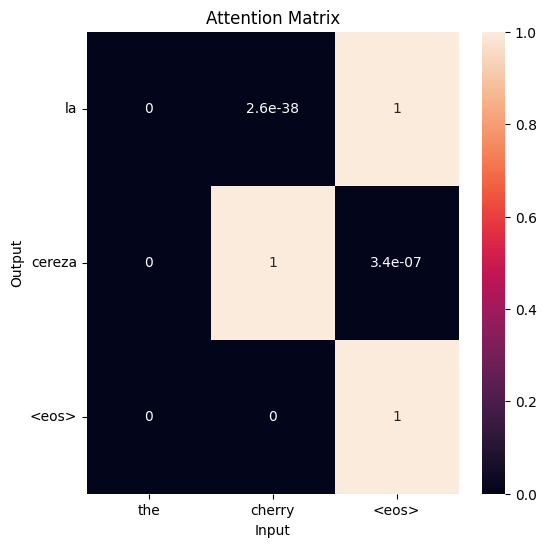

In [139]:
show_att_matrix("the cherry", model, translation)

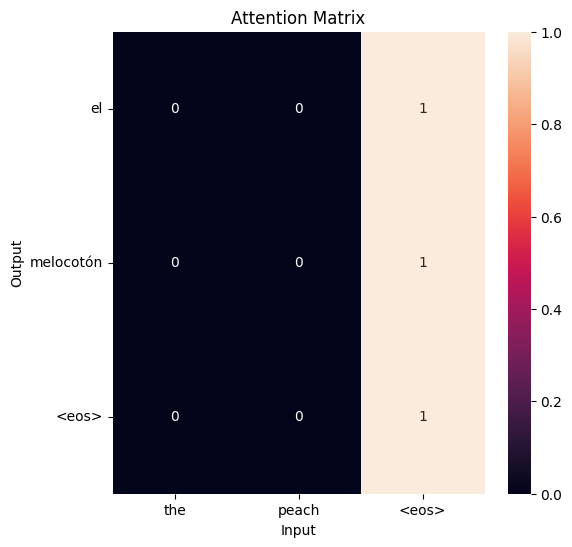

In [140]:
show_att_matrix("the peach", model, translation)

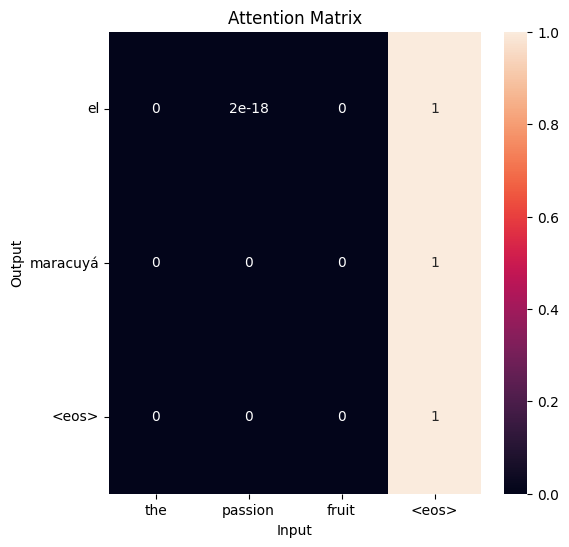

In [ ]:
show_att_matrix("the passion fruit", model, translation)

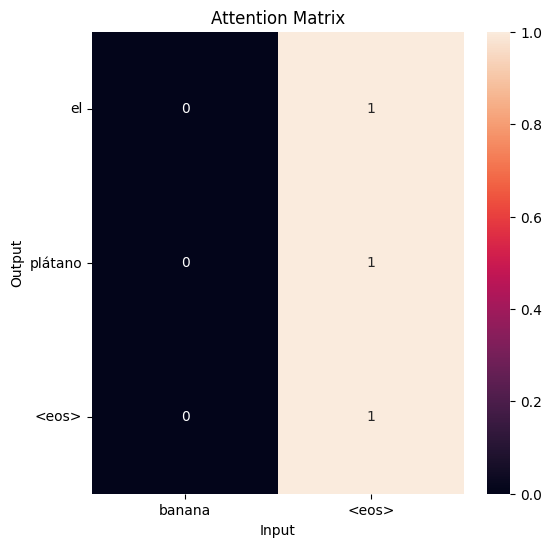

In [148]:
show_att_matrix("banana", model, translation)

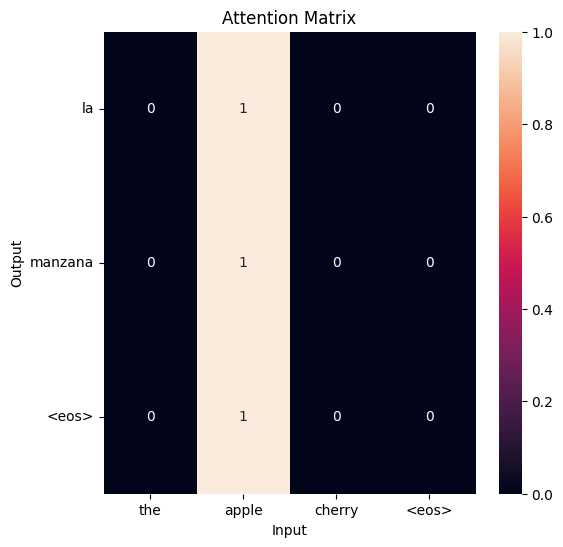

In [156]:
show_att_matrix("the apple cherry", model, translation)

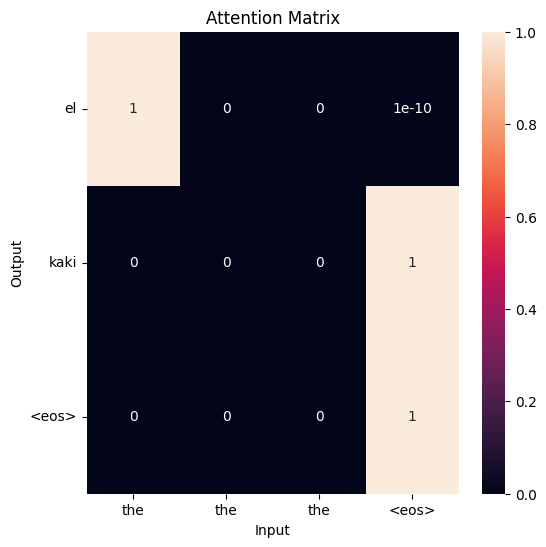

In [161]:
show_att_matrix("the the the", model, translation)

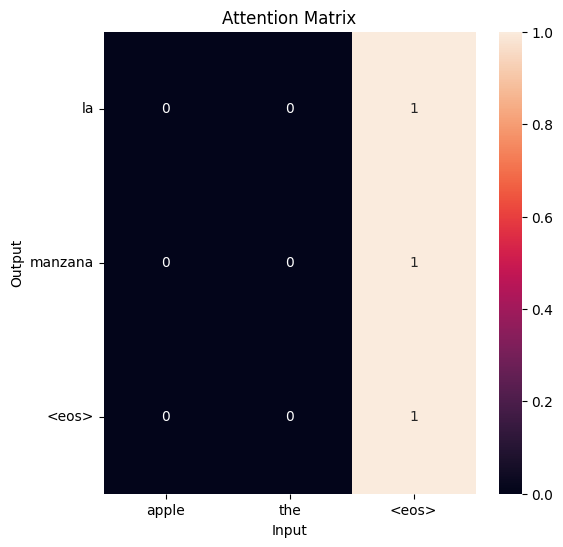

In [167]:
show_att_matrix("apple the", model, translation)

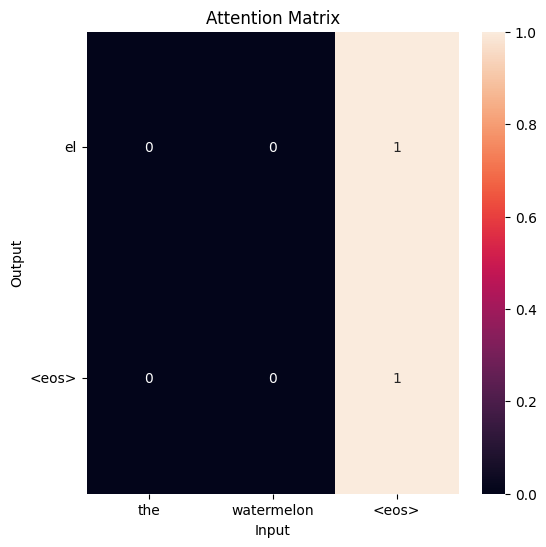

In [172]:
show_att_matrix("the watermelon", model, translation)